In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.environments import Env, Env_ActInf
from src.agents import AgentEWA, AgentQ
import src.helpers as F 

import pymdp
from pymdp import utils
from pymdp.agent import Agent as AgentActInf


np.random.seed(1047)

## Active Inference

In [2]:
# single run analysis with parameters
# belief evolution example
# episodes aand avg returns

In [2]:
def single_run_rewards(choice_hist, context_hist):
    """
    Return  reward array (for single run)
            mean reward
            mean of optimal choices
    """

    choices = np.zeros(choice_hist.shape[1])

    for i, choice_row in enumerate(choice_hist):
        for j, choice_t in enumerate(choice_row):
            if choice_t == 1.0:
                choices[j] = i

    choices_trialsonly = choices[1:] - 1
    optimal_choices = [(i == j) for i,j in zip(context_hist, choices_trialsonly)]
    rewards = [4 if c else -2 for c in optimal_choices]
    
    return np.array(rewards), np.mean(rewards), np.mean(optimal_choices)

### single run parameter exploration

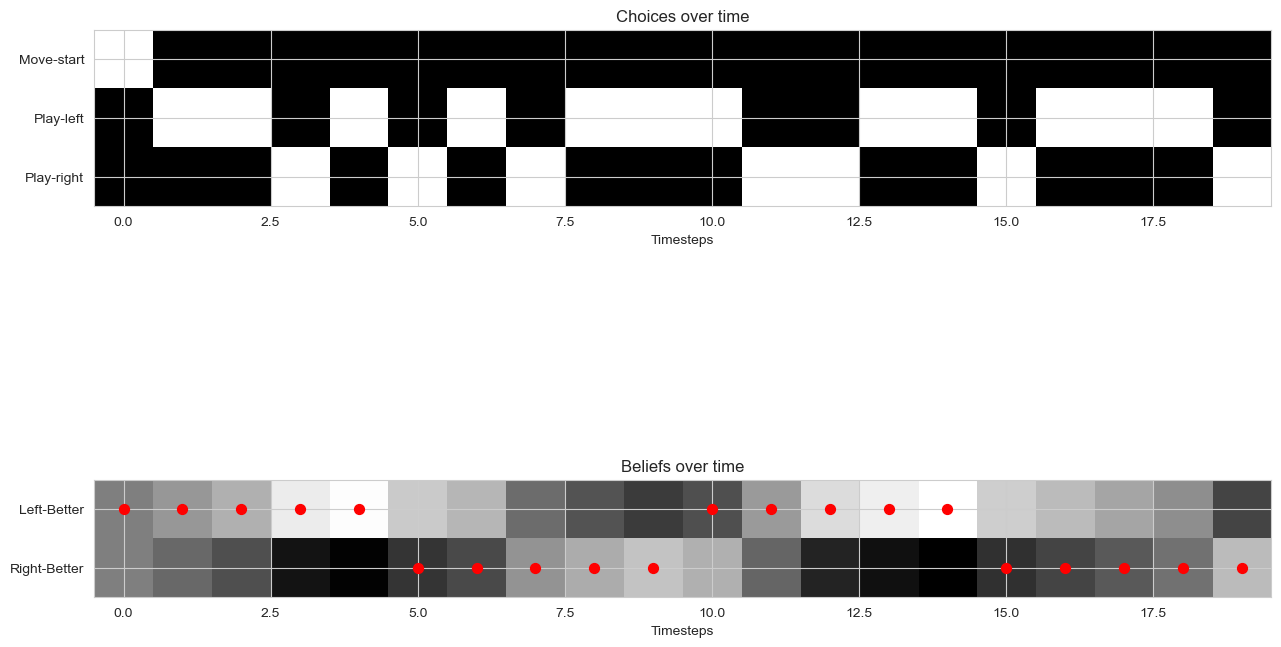

In [87]:
# actinf agent
RUN_LENGTH = 20

switch_at = [4,9,14]

env_actinf = Env_ActInf(p_reward=1, context=0)


actinf_model = F.MDPGenerativeModel()
A, B, C, D = (actinf_model.create_A(p_reward=0.70),                 # explore
              actinf_model.create_B(), 
              actinf_model.create_C(reward=4, pun=-2), 
              actinf_model.create_D()
              )
pA = F.parameterize_pA(A_base=A, scale = 1.0, prior_count=10e5)

agent_actinf = AgentActInf(A=A, pA=pA, B=B, C=C, D=D, 
                           modalities_to_learn=[1],
                           lr_pA = 1,                               # explore
                           use_param_info_gain=True, 
                           action_selection='deterministic')

choice_hist, belief_hist, qA_hist, context_hist = (actinf_model
                                                        .run_active_inference_with_learning(agent_actinf, 
                                                                                            env_actinf, 
                                                                                            T=RUN_LENGTH, 
                                                                                            t_change=switch_at, 
                                                                                            verbose=False)
                                                        )
rewards, mean_rew, p_optimal = single_run_rewards(choice_hist, context_hist)
F.plot_choices_beliefs(choice_hist, belief_hist, context_hist, choice_action_names=actinf_model.choice_action_names)


### many episodes

In [94]:
EPISODES = 2000
RUN_LENGTH = 50

A, B, C, D = (actinf_model.create_A(p_reward=0.70),                 # explore
              actinf_model.create_B(), 
              actinf_model.create_C(reward=4, pun=-2), 
              actinf_model.create_D()
              )
pA = F.parameterize_pA(A_base=A, scale = 1.0, prior_count=10e5)

agent_actinf = AgentActInf(A=A, pA=pA, B=B, C=C, D=D, 
                           modalities_to_learn=[1],
                           lr_pA = 1,                               # explore
                           use_param_info_gain=True, 
                           action_selection='deterministic')

# arrays to hold returns etc
returns = np.zeros([EPISODES, RUN_LENGTH])
mean_rewards = np.zeros(EPISODES)
optimal_choices = np.zeros_like(mean_rewards)

for episode in range(EPISODES):
    choice_hist, belief_hist, qA_hist, context_hist = (actinf_model
                                                            .run_active_inference_with_learning(agent_actinf, 
                                                                                                env_actinf, 
                                                                                                T=RUN_LENGTH, 
                                                                                                t_change=switch_at, 
                                                                                                verbose=False)
                                                                )
    rewards, mean_rew, p_optimal = single_run_rewards(choice_hist, context_hist)
    returns[episode, :] = rewards
    mean_rewards[episode] = mean_rew
    optimal_choices[episode] = p_optimal

In [23]:
# np.save("returns.npy", returns)
# np.save("mean_rewards.npy", mean_rewards)
# np.save("optimal_choices.npy", optimal_choices)

### do the agents on average improve over time?

In [102]:
plt.style.use('ggplot')

slope: 0.00048749099639854807


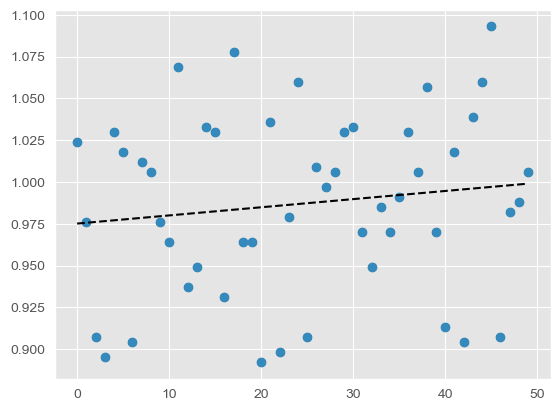

In [103]:
x = np.arange(RUN_LENGTH)
y = np.mean(returns, axis=0)
plt.scatter(x, y)
# plt.xlim()

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 

plt.plot(x,y, 'C1o', x, poly1d_fn(x), '--k')
print(f"slope: {coef[0]}")

In [104]:
np.mean(optimal_choices)

0.49784

hmmmm, kind of.. ?

(-4.0, 4.0)

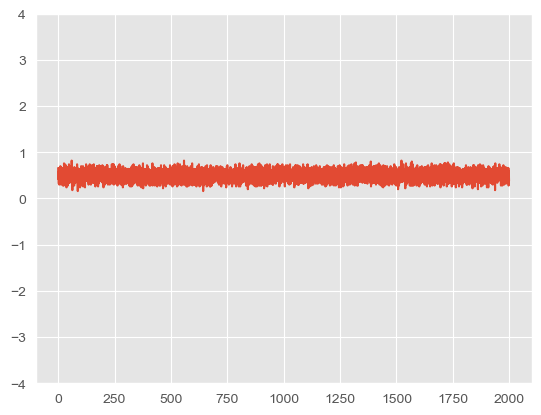

In [98]:
# plt.plot(np.mean(returns, axis=0)) # plot returns etc
plt.plot(optimal_choices)
plt.ylim(-4, 4)

## Q-learning

In [18]:
# sns.set_style('whitegrid')
plt.style.use('ggplot')

### simulation

In [4]:
high_low_var = (4, -2, 0)
env = Env(payoff_structure=high_low_var)

EPISODES = 2000
RUN_LENGTH = 1000

""" arrays to hold returns and Q values history"""
# Q agents
returns_Q_greedy, qvals_Q_greedy = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_Q_smart, qvals_Q_smart = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_Q_smart_soc, qvals_Q_smart_soc = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_Q_social, qvals_Q_social = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])

""" simulation """

for episode in range(EPISODES):

    agentQ_greedy = AgentQ("Q greedy", epsilon=0, is_social=False)
    agentQ_smart = AgentQ('Q smart', epsilon=0.5, is_social=False)
    agentQ_smart_soc = AgentQ('Q smart social', epsilon=0.25, is_social=True)
    agentQ_social = AgentQ("Q social", epsilon=0.25, is_social=True)


    """
        >> add all agents to the list below
    """
    agent_list = [agentQ_greedy, agentQ_smart, agentQ_smart_soc, agentQ_social] 

    env.reset()

    for i in range(RUN_LENGTH):
        actions_this_round = {}
        actions_last_round =  None if (i == 0) else env.history[-1] # TODO?

        if i % 250 == 0:
            # switch reward probabilities, reset 'smart' agents 
            env.switch()
            agentQ_smart.reset_Qvals()
            agentQ_smart_soc.reset_Qvals()

        for agent in agent_list:
            choice = agent.choose_action(context=actions_last_round)
            actions_this_round[agent.id] = choice
            reward, is_optimal = env.return_rewards(choice)
            agent.update_state(reward, is_optimal)
            agent.update_Qvals(choice, reward)

        env.history.append(actions_this_round)
        
    # Store returns at the end of an episode
    returns_Q_greedy[episode, :] = agentQ_greedy.payoffs
    returns_Q_smart[episode, :] = agentQ_smart.payoffs
    returns_Q_smart_soc[episode, :] = agentQ_smart_soc.payoffs
    returns_Q_social[episode, :] = agentQ_social.payoffs

    # Do the same for Q values
    qvals_Q_greedy[:, :, episode] = np.array(agentQ_greedy.Q_vals)
    qvals_Q_smart[:, :, episode] = np.array(agentQ_smart.Q_vals)
    qvals_Q_smart_soc[:, :, episode] = np.array(agentQ_smart_soc.Q_vals)
    qvals_Q_social[:, :, episode] = np.array(agentQ_social.Q_vals)

### reward analysis

In [5]:
returns_all =  (returns_Q_greedy, returns_Q_smart, returns_Q_smart_soc, returns_Q_social)

for ret in returns_all:
    print(np.mean(ret))

0.994
2.49556
1.949272
1.945945


(-5.0, 5.0)

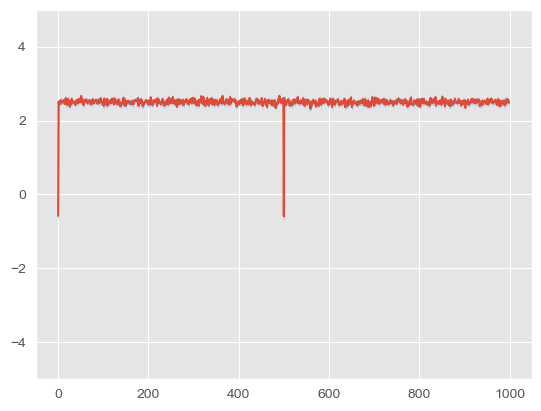

In [23]:
F.plot_returns(returns_Q_smart)
plt.ylim(-5,5)

### Q value analysis

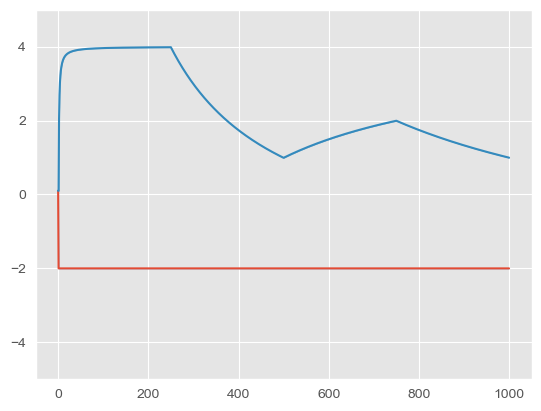

In [24]:
def plot_Qvals(qvals):
    mean = np.mean(qvals, axis=2)
    std_err = np.std(qvals, axis=2) / np.sqrt(qvals.shape[2])
    fig, ax = plt.subplots()
    ax.plot(mean)

    ax.fill_between(range(mean.shape[0]), mean[:,0] + std_err[:,0], mean[:,0] - std_err[:,0], alpha=0.8, color='xkcd:light blue')
    ax.fill_between(range(mean.shape[0]), mean[:,1] + std_err[:,1], mean[:,1] - std_err[:,1], alpha=0.3, color='C1')

    plt.ylim(-5,5)

plot_Qvals(qvals_Q_greedy)

## EWA

In [ ]:
plt.style.use('ggplot')

### simulation

In [29]:
# env = Env(payoff_structure=(0.6, 0.3, 0.1))
high_low_var = (4, -2, 0)
env = Env(payoff_structure=high_low_var)

EPISODES = 2000
RUN_LENGTH = 1000

""" arrays to hold returns and Q values history"""

# EWA agents
returns_EWA, qvals_EWA = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_smart, qvals_EWA_smart = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_conform, qvals_EWA_conform = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_ind, qvals_EWA_ind = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_risk_averse, qvals_EWA_risk_averse = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])
returns_EWA_risk_taker, qvals_EWA_risk_taker = np.zeros([EPISODES, RUN_LENGTH]), np.zeros([RUN_LENGTH+1, 2, EPISODES])


""" simulation """

for episode in range(EPISODES):

    agentEWA = AgentEWA('EWA default', is_social=True)
    agentEWA_smart = AgentEWA('EWA smart', is_social=True)
    agentEWA_conform = AgentEWA('EWA conformist', sigma=0.75, theta=4, is_social=True)
    agentEWA_ind = AgentEWA('EWA individualist', sigma=0.25, theta=0.5, is_social=True)
    agentEWA_risk_averse = AgentEWA('EWA asocial ', lam=0.2, is_social=True)
    agentEWA_risk_taker = AgentEWA('EWA asocial ', lam=4, is_social=True)


    """
        >> add all agents to the list below
    """
    agent_list = [agentEWA, agentEWA_smart, agentEWA_conform, agentEWA_ind, agentEWA_risk_averse, agentEWA_risk_taker] 

    env.reset()

    for i in range(RUN_LENGTH):
        actions_this_round = {}
        actions_last_round =  None if (i == 0) else env.history[-1] # TODO?

        if i % 250 == 0:
            # switch reward probabilities, reset 'smart' agents 
            env.switch()
            agentEWA_smart.reset_Qvals()

        for agent in agent_list:
            choice = agent.choose_action(context=actions_last_round)
            actions_this_round[agent.id] = choice
            reward, is_optimal = env.return_rewards(choice)
            agent.update_state(reward, is_optimal)
            agent.update_Qvals(choice, reward)

        env.history.append(actions_this_round)
    

    # Store returns at the end of an episode
    returns_EWA[episode, :] = agentEWA.payoffs
    returns_EWA_smart[episode, :] = agentEWA_smart.payoffs
    returns_EWA_conform[episode, :] = agentEWA_conform.payoffs
    returns_EWA_ind[episode, :] = agentEWA_ind.payoffs
    returns_EWA_risk_taker[episode, :] = agentEWA_risk_taker.payoffs
    returns_EWA_risk_averse[episode, :] = agentEWA_risk_averse.payoffs

    # Do the same for Q values
   
    qvals_EWA[:, :, episode] = np.array(agentEWA.Q_vals)
    qvals_EWA_smart[:, :, episode] = np.array(agentEWA.Q_vals)
    qvals_EWA_conform[:, :, episode] = np.array(agentEWA_conform.Q_vals)
    qvals_EWA_ind[:, :, episode] = np.array(agentEWA_ind.Q_vals)
    qvals_EWA_risk_taker[:, :, episode] = np.array(agentEWA_risk_taker.Q_vals)
    qvals_EWA_risk_averse[:, :, episode] = np.array(agentEWA_risk_averse.Q_vals)



### reward analysis

In [30]:
returns_all =  (returns_EWA, returns_EWA_smart, returns_EWA_conform, returns_EWA_ind,
                returns_EWA_risk_taker, returns_EWA_risk_averse)

for ret in returns_all:
    print(np.mean(ret))

1.411465
1.412041
1.519801
1.299757
1.411129
1.410901


(-5.0, 5.0)

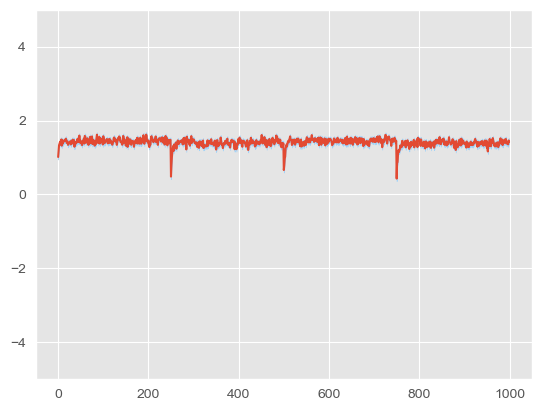

In [28]:
F.plot_returns(returns_EWA)
plt.ylim(-5,5)

### Q value analysis

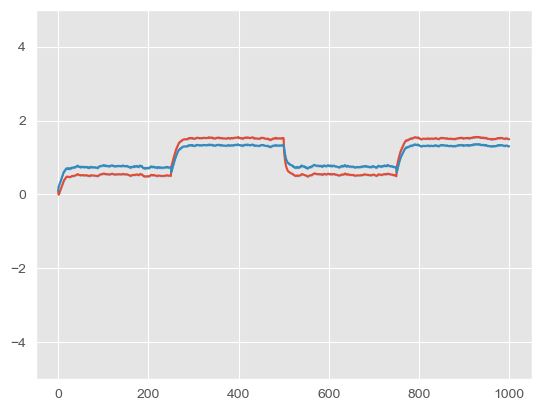

In [31]:
plot_Qvals(qvals_EWA)

In [ ]:
print(np.mean(agentEWA1.correct), np.mean(agentQ1.correct) )

0.501 0.476


446.84698492019896 441.1802904727145


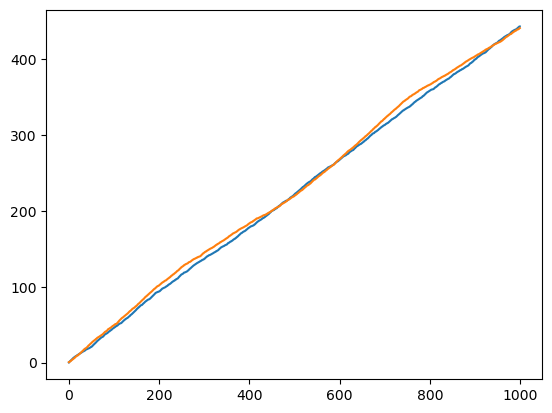

In [ ]:
# plt.plot(np.cumsum(agentEWA1.payoffs))
plt.plot(np.cumsum(agentEWA2.payoffs))
plt.plot(np.cumsum(agentQ1.payoffs))

print(np.sum(agentEWA1.payoffs),np.sum(agentQ1.payoffs))